In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
sugataghosh_google_word2vec_path = kagglehub.dataset_download('sugataghosh/google-word2vec')
saurabhshahane_ecommerce_text_classification_path = kagglehub.dataset_download('saurabhshahane/ecommerce-text-classification')

print('Data source import complete.')


Data source import complete.


<h2><center> <span style = "font-family: Babas; font-size: 2em;"> E-commerce Text Classification </span> </center></h2>
<h4><center> <span style = "font-family: Babas; font-size: 2em; font-style: italic"> With TF-IDF and Word2Vec </span> </center></h4>
<h4><center> <span style = "font-family: Babas; font-size: 2em;"> Sugata Ghosh </span> </center></h4>

---

### Overview

The objective of the project is to classify [**e-commerce**](https://en.wikipedia.org/wiki/E-commerce) products into four categories, based on its description available in the e-commerce platforms. The categories are: `Electronics`, `Household`, `Books`, and `Clothing & Accessories`. We carried out the following steps in this notebook:

- Performed basic [**exploratory data analysis**](https://en.wikipedia.org/wiki/Exploratory_data_analysis), comparing the distributions of the number of characters, number of words, and average word-length of descriptions of products from different categories.
- Employed several [**text normalization**](https://en.wikipedia.org/wiki/Text_normalization) techniques on product descriptions.
- Used [**TF-IDF**](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) vectorizer on the normalized product descriptions for **text vectorization**, compared the baseline performance of several classifiers, and performed [**hyperparameter tuning**](https://en.wikipedia.org/wiki/Hyperparameter_optimization) on the [**support vector machine**](https://en.wikipedia.org/wiki/Support-vector_machine) classifier with **linear kernel**.
- In a separate direction, employed a few selected **text normalization** processes, namely **convertion to lowercase** and **substitution of [contractions](https://en.wikipedia.org/wiki/Wikipedia:List_of_English_contractions)** on the raw data on product descriptions; used [**Google**](https://en.wikipedia.org/wiki/Google)'s pre-trained [**Word2Vec**](https://en.wikipedia.org/wiki/Word2vec) model on the tokens, obtained from the partially normalized descriptions, to get the [**embeddings**](https://en.wikipedia.org/wiki/Word_embedding), which are then converted to [**compressed sparse row**](https://en.wikipedia.org/wiki/Sparse_matrix) (CSR) format; compared the baseline performance of several classifiers, and performed [**hyperparameter tuning**](https://en.wikipedia.org/wiki/Hyperparameter_optimization) on the [**XGBoost**](https://en.wikipedia.org/wiki/XGBoost) classifier.
- Employed the model with the highest validation accuracy to predict the labels of the test observations and obtained a test accuracy of $0.948939$.

---

### Contents

- [**Introduction**](#Introduction)
    - [E-commerce Product Categorization](#E-commerce-Product-Categorization)
    - [Text Classification](#Text-Classification)
    - [Data](#Data)
    - [Project Objective](#Project-Objective)
- [**Exploratory Data Analysis**](#Exploratory-Data-Analysis)
    - [Class Frequencies](#Class-Frequencies)
    - [Number of Characters](#Number-of-Characters)
    - [Number of Words](#Number-of-Words)
    - [Average Word-length](#Average-Word-length)
- [**Train-Validation-Test Split**](#Train-Validation-Test-Split)
- [**Text Normalization**](#Text-Normalization)
    - [Convertion to Lowercase](#Convertion-to-Lowercase)
    - [Removal of Whitespaces](#Removal-of-Whitespaces)
    - [Removal of Punctuations](#Removal-of-Punctuations)
    - [Removal of Unicode Characters](#Removal-of-Unicode-Characters)
    - [Substitution of Acronyms](#Substitution-of-Acronyms)
    - [Substitution of Contractions](#Substitution-of-Contractions)
    - [Removal of Stop Words](#Removal-of-Stop-Words)
    - [Spelling Correction](#Spelling-Correction)
    - [Stemming and Lemmatization](#Stemming-and-Lemmatization)
    - [Discardment of Non-alphabetic Words](#Discardment-of-Non-alphabetic-Words)
    - [Retainment of Relevant Parts of Speech](#Retainment-of-Relevant-Parts-of-Speech)
    - [Removal of Additional Stop Words](#Removal-of-Additional-Stop-Words)
    - [Integration of the Processes](#Integration-of-the-Processes)
    - [Implementation on Product Description](#Implementation-on-Product-Description)
- [**TF-IDF Model**](#TF-IDF-Model)
    - [Text Vectorization](#Text-Vectorization)
    - [TF-IDF Baseline Modeling](#TF-IDF-Baseline-Modeling)
    - [TF-IDF Hyperparameter Tuning](#TF-IDF-Hyperparameter-Tuning)
- [**Word2Vec Model**](#Word2Vec-Model)
    - [Partial Text Normalization](#Partial-Text-Normalization)
    - [Word Embedding](#Word-Embedding)
    - [Word2Vec Baseline Modeling](#Word2Vec-Baseline-Modeling)
    - [Word2Vec Hyperparameter Tuning](#Word2Vec-Hyperparameter-Tuning)
- [**Final Prediction and Evaluation**](#Final-Prediction-and-Evaluation)
- [**Acknowledgements**](#Acknowledgements)
- [**References**](#References)

### Importing libraries

In [1]:
# File system manangement
import time, psutil, os

# Data manipulation
import numpy as np
import pandas as pd

# Plotting and visualization
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
sns.set_theme()
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

# NLP
import string, re, nltk
from string import punctuation
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
!pip install num2words
from num2words import num2words
!pip install pyspellchecker
from spellchecker import SpellChecker
from nltk.stem.porter import PorterStemmer
import spacy
from nltk.stem import WordNetLemmatizer

# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

# Scipy
import scipy
from scipy import sparse
from scipy.sparse import csr_matrix

# Train-test split and cross validation
from sklearn.model_selection import train_test_split, ParameterGrid

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import RidgeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier

# Model evaluation
from sklearn import metrics
from sklearn.metrics import accuracy_score

# Others
!pip install gensim
import json
import gensim
from sklearn.decomposition import TruncatedSVD

In [2]:
!pip install --upgrade --force-reinstall numpy==1.26.4 scipy==1.13.0 gensim==4.3.3

  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.8 MB/s eta 0:00:00
  Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.1 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 69.6 MB/s eta 0:00:00
Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.7 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 9.4 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.2
    Uninstalling wrapt-1.17.2:
      Successfully uninstalled wrapt-1.17.2
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstall

### Runtime and memory usage

In [ ]:
# Recording the starting time, complemented with a stopping time check in the end to compute process runtime
start = time.time()

# Class representing the OS process and having memory_info() method to compute process memory usage
process = psutil.Process(os.getpid())

# Introduction

- [**E-commerce Product Categorization**](#E-commerce-Product-Categorization)
- [**Text Classification**](#Text-Classification)
- [**Data**](#Data)
- [**Project Objective**](#Project-Objective)

## E-commerce Product Categorization

**E-commerce** (electronic commerce) is the activity of electronically buying or selling of products on online services or over the [**Internet**](https://en.wikipedia.org/wiki/Internet). It frequently uses the [**web**](https://en.wikipedia.org/wiki/World_Wide_Web), if not entirely, for at least some of the life cycle of a transaction, while it may also use other technologies like [**e-mail**](https://en.wikipedia.org/wiki/Email). Typical e-commerce transactions include the purchase of products (like books from Amazon) or services (such as music downloads in the form of digital distribution such as the iTunes Store). [**Online retail**](https://en.wikipedia.org/wiki/Online_shopping), [**electronic markets**](https://en.wikipedia.org/wiki/Electronic_markets), and [**online auctions**](https://en.wikipedia.org/wiki/Online_auction) are the three areas of e-commerce. E-commerce is supported by [**electronic business**](https://en.wikipedia.org/wiki/Electronic_business). The purpose of e-commerce is to enable customers to shop and pay online over the Internet, saving both time and space for consumers and businesses while also significantly improving transaction efficiency.

**Product categorization** or [**product classification**](https://en.wikipedia.org/wiki/Product_classification) is a type of [**economic taxonomy**](https://en.wikipedia.org/wiki/Economic_taxonomy) that refers to a system of categories into which a collection of products would fall under. Product categorization involves two separate tasks:

- Create, support, and expand the catalogue structure for the offered products.
- Tagging products with the correct categories and attributes.

While machine learning does not have much potential for use in the first task, it is possible to automate the second task, which is relatively laborious and time-consuming. **The problem considered in this notebook involves the categorization of products offered on e-commerce platforms based on the descriptions of the products mentioned therein.** The purpose of such categorization is to enhance the user experience and achieve better results with external search engines. Visitors can quickly find the products they need by navigating the catalogue or using the website's search engine.

## Text Classification

**Text classification** is a widely used [**natural language processing**](https://en.wikipedia.org/wiki/Natural_language_processing) task in different business problems. Given a statement or document, the task involves assigning to it an appropriate category from a pre-defined set of categories. The dataset of choice determines the set of categories. Text classification has applications in emotion classification, news classification, spam email detection, auto-tagging of customer queries etc.

In the present problem, the statements are the product descriptions and the categories are `Electronics`, `Household`, `Books` and `Clothing & Accessories`.

## Data

**Original source:** **https://doi.org/10.5281/zenodo.3355823**

**Kaggle dataset:** **https://www.kaggle.com/datasets/saurabhshahane/ecommerce-text-classification**

The dataset has been scraped from Indian e-commerce platform(s). It contains e-commerce text data for four categories: `Electronics`, `Household`, `Books` and `Clothing & Accessories`. Roughly speaking, these four categories cover $80\%$ of any e-commerce website, by and large. The dataset is in *.csv* format and consists of two columns. The first column gives the target class name and the second column gives the datapoint, which is the description of the product from the e-commerce website. We insert column names and swap the columns, to put the target column at the right.

In [2]:
# Loading and customizing the data
data = pd.read_csv(
    'https://raw.githubusercontent.com/sugatagh/E-commerce-Text-Classification/main/Dataset/ecommerceDataset.csv',
    names = ['label', 'description']
)
data = data[['description', 'label']]

print(pd.Series({"Memory usage": "{:.2f} MB".format(data.memory_usage().sum()/(1024*1024)),
                 "Dataset shape": "{}".format(data.shape)}).to_string())
data

Memory usage        0.77 MB
Dataset shape    (50425, 2)


,description,label
0,Paper Plane Design Framed Wall Hanging Motivat...,Household
1,"SAF 'Floral' Framed Painting (Wood, 30 inch x ...",Household
2,SAF 'UV Textured Modern Art Print Framed' Pain...,Household
3,"SAF Flower Print Framed Painting (Synthetic, 1...",Household
4,Incredible Gifts India Wooden Happy Birthday U...,Household
...,...,...
50420,Strontium MicroSD Class 10 8GB Memory Card (Bl...,Electronics
50421,CrossBeats Wave Waterproof Bluetooth Wireless ...,Electronics
50422,Karbonn Titanium Wind W4 (White) Karbonn Titan...,Electronics
50423,"Samsung Guru FM Plus (SM-B110E/D, Black) Colou...",Electronics


In [3]:
# Example description
data['description'].iloc[0]

'Paper Plane Design Framed Wall Hanging Motivational Office Decor Art Prints (8.7 X 8.7 inch) - Set of 4 Painting made up in synthetic frame with uv textured print which gives multi effects and attracts towards it. This is an special series of paintings which makes your wall very beautiful and gives a royal touch. This painting is ready to hang, you would be proud to possess this unique painting that is a niche apart. We use only the most modern and efficient printing technology on our prints, with only the and inks and precision epson, roland and hp printers. This innovative hd printing technique results in durable and spectacular looking prints of the highest that last a lifetime. We print solely with top-notch 100% inks, to achieve brilliant and true colours. Due to their high level of uv resistance, our prints retain their beautiful colours for many years. Add colour and style to your living space with this digitally printed painting. Some are for pleasure and some for eternal blis

In [4]:
# Missing values and duplicate observations
print(pd.Series({"Number of observations with missing values": len(data) - len(data.dropna()),
                 "Number of duplicate observations": data.duplicated().sum()}).to_string())

Number of observations with missing values        1
Number of duplicate observations              22622


In [5]:
data.dropna(inplace = True) # Dropping observations with missing values
data.drop_duplicates(inplace = True) # Dropping duplicate observations
data.reset_index(drop = True, inplace = True) # Resetting index

The labels are manually encoded with the following scheme:
- **Electronics** $\mapsto$ $0$
- **Household** $\mapsto$ $1$
- **Books** $\mapsto$ $2$
- **Clothing & Accessories** $\mapsto$ $3$

In [6]:
# Manual encoding of labels
label_dict = {'Electronics': 0, 'Household': 1, 'Books': 2, 'Clothing & Accessories': 3}
data.replace({'label': label_dict}, inplace = True)

print(pd.Series({"Memory usage": "{:.2f} MB".format(data.memory_usage().sum()/(1024*1024)),
                 "Dataset shape": "{}".format(data.shape)}).to_string())
data

Memory usage        0.42 MB
Dataset shape    (27802, 2)


<ipython-input-6-2897176373>:3: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



,description,label
0,Paper Plane Design Framed Wall Hanging Motivat...,1
1,"SAF 'Floral' Framed Painting (Wood, 30 inch x ...",1
2,SAF 'UV Textured Modern Art Print Framed' Pain...,1
3,"SAF Flower Print Framed Painting (Synthetic, 1...",1
4,Incredible Gifts India Wooden Happy Birthday U...,1
...,...,...
27797,Micromax Bharat 5 Plus Zero impact on visual d...,0
27798,Microsoft Lumia 550 8GB 4G Black Microsoft lum...,0
27799,"Microsoft Lumia 535 (Black, 8GB) Colour:Black ...",0
27800,Karbonn Titanium Wind W4 (White) Karbonn Titan...,0


## Project Objective

The objective of the project is to classify a product into the four categories `Electronics`, `Household`, `Books` and `Clothing & Accessories`, based on its description available in the e-commerce platform.

# Exploratory Data Analysis

- [**Class Frequencies**](#Class-Frequencies)
- [**Number of Characters**](#Number-of-Characters)
- [**Number of Words**](#Number-of-Words)
- [**Average Word-length**](#Average-Word-length)

We split the dataset based on the target classes, in order to see how different textual attributes vary across classes.

In [7]:
# Splitting the dataset by label
data_e = data[data['label'] == 0] # Electronics
data_h = data[data['label'] == 1] # Household
data_b = data[data['label'] == 2] # Books
data_c = data[data['label'] == 3] # Clothing & Accessories

## Class Frequencies

In [8]:
# Visualization of class frequencies
values = np.array([len(data_e), len(data_h), len(data_b), len(data_c)])
labels = ['Electronics', 'Household', 'Books', 'Clothing & Accessories']
fig = go.Figure(data = [go.Pie(values = values, labels = labels, hole = 0.5, textinfo = 'percent', title = " ")])
text_title = "Comparison of class frequencies"
fig.update_layout(height = 500, width = 800, showlegend = True, title = dict(text = text_title, x = 0.5, y = 0.95))
fig.show()

## Number of Characters

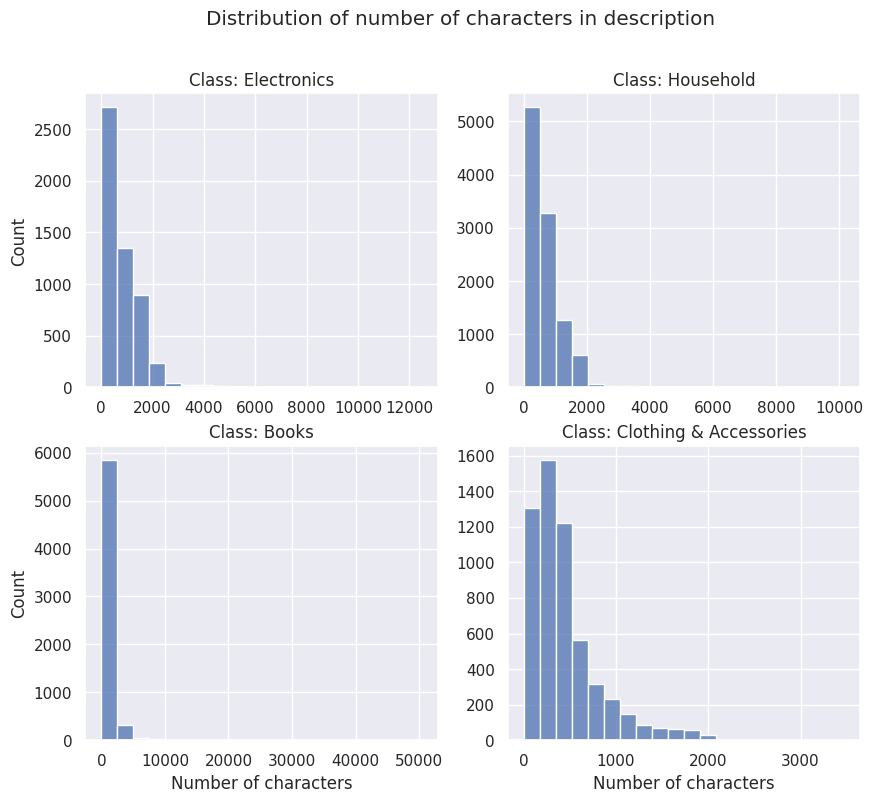

In [9]:
# Distribution of number of characters in description
data_e_char = data_e['description'].str.len()
data_h_char = data_h['description'].str.len()
data_b_char = data_b['description'].str.len()
data_c_char = data_c['description'].str.len()

fig, ax = plt.subplots(2, 2, figsize = (10, 8.4), sharey = False)
sns.histplot(x = data_e_char, bins = 20, ax = ax[0, 0]).set_title('Class: Electronics')
sns.histplot(x = data_h_char, bins = 20, ax = ax[0, 1]).set_title('Class: Household')
sns.histplot(x = data_b_char, bins = 20, ax = ax[1, 0]).set_title('Class: Books')
sns.histplot(x = data_c_char, bins = 20, ax = ax[1, 1]).set_title('Class: Clothing & Accessories')

fig.suptitle("Distribution of number of characters in description")
for i in range(4):
    ax[i // 2, i % 2].set_xlabel(" ") if i // 2 == 0 else ax[i // 2, i % 2].set_xlabel("Number of characters")
    if i % 2 != 0: ax[i // 2, i % 2].set_ylabel(" ")

## Number of Words

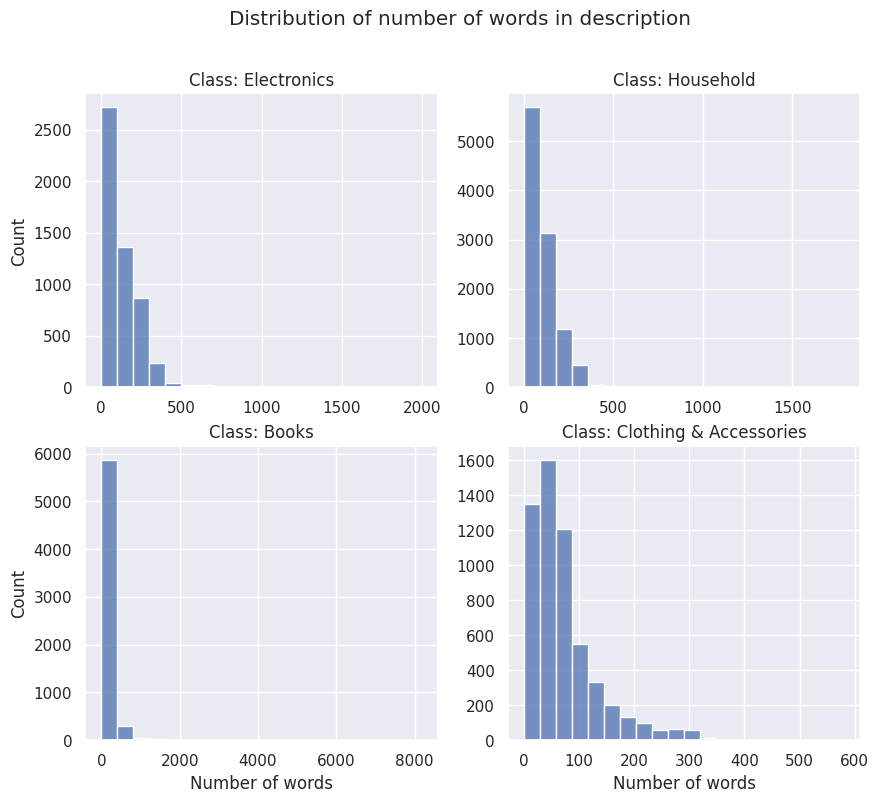

In [10]:
# Distribution of number of words in description
data_e_word = data_e['description'].str.split().map(lambda x: len(x))
data_h_word = data_h['description'].str.split().map(lambda x: len(x))
data_b_word = data_b['description'].str.split().map(lambda x: len(x))
data_c_word = data_c['description'].str.split().map(lambda x: len(x))

fig, ax = plt.subplots(2, 2, figsize = (10, 8.4), sharey = False)
sns.histplot(x = data_e_word, bins = 20, ax = ax[0, 0]).set_title('Class: Electronics')
sns.histplot(x = data_h_word, bins = 20, ax = ax[0, 1]).set_title('Class: Household')
sns.histplot(x = data_b_word, bins = 20, ax = ax[1, 0]).set_title('Class: Books')
sns.histplot(x = data_c_word, bins = 20, ax = ax[1, 1]).set_title('Class: Clothing & Accessories')

fig.suptitle("Distribution of number of words in description")
for i in range(4):
    ax[i // 2, i % 2].set_xlabel(" ") if i // 2 == 0 else ax[i // 2, i % 2].set_xlabel("Number of words")
    if i % 2 != 0: ax[i // 2, i % 2].set_ylabel(" ")

## Average Word-length

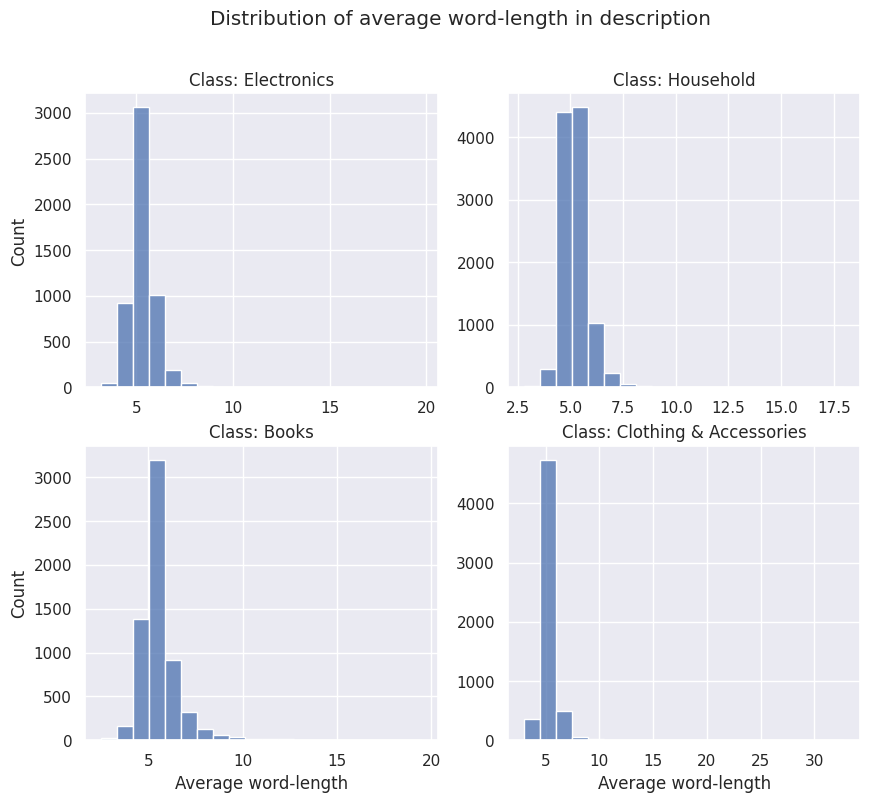

In [11]:
# Distribution of average word-length in description
data_e_avg = data_e['description'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x))
data_h_avg = data_h['description'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x))
data_b_avg = data_b['description'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x))
data_c_avg = data_c['description'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x))

fig, ax = plt.subplots(2, 2, figsize = (10, 8.4), sharey = False)
sns.histplot(x = data_e_avg, bins = 20, ax = ax[0, 0]).set_title('Class: Electronics')
sns.histplot(x = data_h_avg, bins = 20, ax = ax[0, 1]).set_title('Class: Household')
sns.histplot(x = data_b_avg, bins = 20, ax = ax[1, 0]).set_title('Class: Books')
sns.histplot(x = data_c_avg, bins = 20, ax = ax[1, 1]).set_title('Class: Clothing & Accessories')

fig.suptitle("Distribution of average word-length in description")
for i in range(4):
    ax[i // 2, i % 2].set_xlabel(" ") if i // 2 == 0 else ax[i // 2, i % 2].set_xlabel("Average word-length")
    if i % 2 != 0: ax[i // 2, i % 2].set_ylabel(" ")

# Train-Validation-Test Split

In [12]:
# Feature-target split
X, y = data.drop('label', axis = 1), data['label']

# Train-test split (from complete data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 40)
data_train = pd.concat([X_train, y_train], axis = 1)

# Validation-test split (from test data)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state = 40)
data_val, data_test = pd.concat([X_val, y_val], axis = 1), pd.concat([X_test, y_test], axis = 1)

# Comparison of sizes of training set, validation set and test set
values = np.array([len(data_train), len(data_val), len(data_test)])
labels = ['Training set', 'Validation Set', 'Test set']
fig = go.Figure(data = [go.Pie(values = values, labels = labels, hole = 0.5, textinfo = 'percent', title = " ")])
text_title = "Comparison of sizes of training set, validation set and test set"
fig.update_layout(height = 500, width = 800, showlegend = True, title = dict(text = text_title, x = 0.5, y = 0.95))
fig.show()

# Text Normalization

- [**Convertion to Lowercase**](#Convertion-to-Lowercase)
- [**Removal of Whitespaces**](#Removal-of-Whitespaces)
- [**Removal of Punctuations**](#Removal-of-Punctuations)
- [**Removal of Unicode Characters**](#Removal-of-Unicode-Characters)
- [**Substitution of Acronyms**](#Substitution-of-Acronyms)
- [**Substitution of Contractions**](#Substitution-of-Contractions)
- [**Removal of Stop Words**](#Removal-of-Stop-Words)
- [**Spelling Correction**](#Spelling-Correction)
- [**Stemming and Lemmatization**](#Stemming-and-Lemmatization)
- [**Discardment of Non-alphabetic Words**](#Discardment-of-Non-alphabetic-Words)
- [**Retainment of Relevant Parts of Speech**](#Retainment-of-Relevant-Parts-of-Speech)
- [**Removal of Additional Stop Words**](#Removal-of-Additional-Stop-Words)
- [**Integration of the Processes**](#Integration-of-the-Processes)
- [**Implementation on Product Description**](#Implementation-on-Product-Description)

In natural language processing, **text normalization** is the process of transforming text into a single canonical form. We consider a number of text normalization processes. At the end of the section, we combine selected processes into one single function and apply it on the product descriptions.

In [13]:
# RegexpTokenizer
regexp = RegexpTokenizer("[\w']+")

## Convertion to Lowercase

We convert all alphabetical characters of the tweets to lowercase so that the models do not differentiate identical words due to case-sensitivity. For example, without the normalization, *Sun* and *sun* would have been treated as two different words, which is not useful in the present context.

In [14]:
# Converting to lowercase
def convert_to_lowercase(text):
    return text.lower()

text = "This is a FUNCTION that CoNvErTs a Text to lowercase"
print("Input: {}".format(text))
print("Output: {}".format(convert_to_lowercase(text)))

Input: This is a FUNCTION that CoNvErTs a Text to lowercase
Output: this is a function that converts a text to lowercase


## Removal of Whitespaces

We remove the unnecessary empty spaces from the description of the observations.

In [15]:
# Removing whitespaces
def remove_whitespace(text):
    return text.strip()

text = " \t This is a string \t "
print("Input: {}".format(text))
print("Output: {}".format(remove_whitespace(text)))

Input:  	 This is a string 	 
Output: This is a string


## Removal of Punctuations

Mostly the punctuations do not play any role in predicting whether a particular tweet indicate disaster or not. Thus we prevent them from contaminating the classification procedures by removing them from the tweets. However, we keep **apostrophe** since most of the contractions contain this punctuation and will be automatically taken care of once we convert the contractions.

In [16]:
# Removing punctuations
def remove_punctuation(text):
    punct_str = string.punctuation
    punct_str = punct_str.replace("'", "") # discarding apostrophe from the string to keep the contractions intact
    return text.translate(str.maketrans("", "", punct_str))

text = "Here's [an] example? {of} &a string. with.? punctuations!!!!"
print("Input: {}".format(text))
print("Output: {}".format(remove_punctuation(text)))

Input: Here's [an] example? {of} &a string. with.? punctuations!!!!
Output: Here's an example of a string with punctuations


## Removal of Unicode Characters

The training tweets are typically sprinkled with emojis, URLs, punctuation and other symbols that do not contribute meaningfully to our analysis, but instead create noise in the learning procedure. Some of these symbols are unique, while the rest usually translate into unicode strings. We remove these irrelevant characters from the data using the regular expression module.

In [17]:
# Removing HTML tags
def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'', text)

text = '<a href = "https://www.kaggle.com/datasets/saurabhshahane/ecommerce-text-classification"> Ecommerce Text Classification </a>'
print("Input: {}".format(text))
print("Output: {}".format(remove_html(text)))

Input: <a href = "https://www.kaggle.com/datasets/saurabhshahane/ecommerce-text-classification"> Ecommerce Text Classification </a>
Output:  Ecommerce Text Classification 


In [18]:
# Removing emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags = re.UNICODE)
    return emoji_pattern.sub(r'', text)

text = "This innovative hd printing technique results in durable and spectacular looking prints 😊"
print("Input: {}".format(text))
print("Output: {}".format(remove_emoji(text)))

Input: This innovative hd printing technique results in durable and spectacular looking prints 😊
Output: This innovative hd printing technique results in durable and spectacular looking prints 


In [19]:
# Removing other unicode characters
def remove_http(text):
    http = "https?://\S+|www\.\S+" # matching strings beginning with http (but not just "http")
    pattern = r"({})".format(http) # creating pattern
    return re.sub(pattern, "", text)

text = "It's a function that removes links starting with http: or https such as https://en.wikipedia.org/wiki/Unicode_symbols"
print("Input: {}".format(text))
print("Output: {}".format(remove_http(text)))

Input: It's a function that removes links starting with http: or https such as https://en.wikipedia.org/wiki/Unicode_symbols
Output: It's a function that removes links starting with http: or https such as 


## Substitution of Acronyms

[**Acronyms**](https://en.wikipedia.org/wiki/Acronym) are shortened forms of phrases, generally found in informal writings. For instance, *for your information* is written as *fyi* and *by the way* is written as *btw*. These time and effort-saving acronyms have received almost universal acceptance in recent times. For the sake of proper modeling, we convert the acronyms, appearing in the tweets, back to their respective original forms.

In [20]:
# Dictionary of acronyms
acronyms_url = 'https://raw.githubusercontent.com/sugatagh/E-commerce-Text-Classification/main/JSON/english_acronyms.json'
acronyms_dict = pd.read_json(acronyms_url, typ = 'series')

print("Example: Original form of the acronym 'fyi' is '{}'".format(acronyms_dict['fyi']))

Example: Original form of the acronym 'fyi' is 'for your information'


In [21]:
# Dataframe of acronyms
pd.DataFrame(acronyms_dict.items(), columns = ['acronym', 'original']).head()

,acronym,original
0,aka,also known as
1,asap,as soon as possible
2,brb,be right back
3,btw,by the way
4,dob,date of birth


In [22]:
# List of acronyms
acronyms_list = list(acronyms_dict.keys())

In [23]:
# Function to convert contractions in a text
def convert_acronyms(text):
    words = []
    for word in regexp.tokenize(text):
        if word in acronyms_list:
            words = words + acronyms_dict[word].split()
        else:
            words = words + word.split()

    text_converted = " ".join(words)
    return text_converted

text = "btw you've to fill in the details including dob"
print("Input: {}".format(text))
print("Output: {}".format(convert_acronyms(text)))

Input: btw you've to fill in the details including dob
Output: by the way you've to fill in the details including date of birth


## Substitution of Contractions

A [**contraction**](https://en.wikipedia.org/wiki/Wikipedia:List_of_English_contractions) is a shortened form of a word or a phrase, obtained by dropping one or more letters.

These are commonly used in everyday speech, written dialogue, informal writing and in situations where space is limited or costly, such as advertisements. Usually the missing letters are indicated by an apostrophe, but there are exceptions. Examples: **I'm = I am**, **let's = let us**, **won't = would not**, **howdy = how do you do**.

We have compiled an extensive list of English contractions, which can be found in the attached .json file titled *english_contractions*. The list is largely based on information obtained from [**this wikipedia page**](https://en.wikipedia.org/wiki/Wikipedia:List_of_English_contractions) on *list of English contractions*. Note that the file only considers contractions in lowercase, i.e. it assumes that the textual data have already been transformed to lowercase before substituting the contractions. For example, the process will convert **i'll** to **i shall** but will leave **I'll** unchanged.

In [24]:
# Dictionary of contractions
contractions_url = 'https://raw.githubusercontent.com/sugatagh/E-commerce-Text-Classification/main/JSON/english_contractions.json'
contractions_dict = pd.read_json(contractions_url, typ = 'series')

print("Example: Original form of the contraction 'aren't' is '{}'".format(contractions_dict["aren't"]))

Example: Original form of the contraction 'aren't' is 'are not'


In [25]:
# Dataframe of contractions
pd.DataFrame(contractions_dict.items(), columns = ['contraction', 'original']).head()

,contraction,original
0,'aight,alright
1,ain't,are not
2,amn't,am not
3,arencha,are not you
4,aren't,are not


The contractions do not always have a one-to-one mapping with the original words. For example **i'd** can come from both **i had** and **i would**. In the .json file only one the original words/phrases are chosen. However, this does not affect our analysis since words like **had** and **would**, which do not have any meaningful contribution in achieving the objective of the project, will be discarded in the next subsection.

In [26]:
# List of contractions
contractions_list = list(contractions_dict.keys())

In [27]:
# Function to convert contractions in a text
def convert_contractions(text):
    words = []
    for word in regexp.tokenize(text):
        if word in contractions_list:
            words = words + contractions_dict[word].split()
        else:
            words = words + word.split()

    text_converted = " ".join(words)
    return text_converted

text = "he's doin' fine"
print("Input: {}".format(text))
print("Output: {}".format(convert_contractions(text)))

Input: he's doin' fine
Output: he is doing fine


## Removal of Stop Words

Several words, primarily pronouns, prepositions, modal verbs etc, are identified not to have much effect on the classification procedure. These are called [**stop words**](https://en.wikipedia.org/wiki/Stop_word). To get rid of the unwanted contamination effect, we remove these words.

In [28]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [29]:
# Stopwords
stops = stopwords.words("english") # stopwords
addstops = ["among", "onto", "shall", "thrice", "thus", "twice", "unto", "us", "would"] # additional stopwords
allstops = stops + addstops

print(allstops)

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

In [30]:
# Function to remove stopwords from a list of texts
def remove_stopwords(text):
    return " ".join([word for word in regexp.tokenize(text) if word not in allstops])

text = "This is a function that removes stopwords in a given text"
print("Input: {}".format(text))
print("Output: {}".format(remove_stopwords(text)))

Input: This is a function that removes stopwords in a given text
Output: This function removes stopwords given text


## Spelling Correction

The classification procedure cannot take mispellings into consideration and treats a word and its misspelt version as separate words. For this reason it is necessary to conduct spelling correction before feeding the data to the classification procedure.

In [31]:
# pyspellchecker
spell = SpellChecker()

def pyspellchecker(text):
    word_list = regexp.tokenize(text)
    word_list_corrected = []
    for word in word_list:
        if word in spell.unknown(word_list):
            word_corrected = spell.correction(word)
            if word_corrected == None:
                word_list_corrected.append(word)
            else:
                word_list_corrected.append(word_corrected)
        else:
            word_list_corrected.append(word)
    text_corrected = " ".join(word_list_corrected)
    return text_corrected

text = "I'm goinng therre"
print("Input: {}".format(text))
print("Output: {}".format(pyspellchecker(text)))

Input: I'm goinng therre
Output: I'm going there


## Stemming and Lemmatization

[**Stemming**](https://en.wikipedia.org/wiki/Stemming) is the process of reducing the words to their root form or **stem**. It reduces related words to the same *stem* even if the stem is not a dictionary word. For example, the words **introducing**, **introduced**, **introduction** reduce to a common word **introduce**. However, the process often produces stems that are not actual words.

In [32]:
# Stemming
stemmer = PorterStemmer()
def text_stemmer(text):
    text_stem = " ".join([stemmer.stem(word) for word in regexp.tokenize(text)])
    return text_stem

text = "Introducing lemmatization as an improvement over stemming"
print("Input: {}".format(text))
print("Output: {}".format(text_stemmer(text)))

Input: Introducing lemmatization as an improvement over stemming
Output: introduc lemmat as an improv over stem


The stems **introduc**, **lemmat** and **improv** are not actual words. [**Lemmatization**](https://en.wikipedia.org/wiki/Lemmatisation) offers a more sophisticated approach by utilizing a corpus to match root forms of the words. Unlike stemming, it uses the context in which a word is being used.

In [33]:
# Lemmatization
spacy_lemmatizer = spacy.load("en_core_web_sm", disable = ['parser', 'ner'])
#lemmatizer = WordNetLemmatizer()

def text_lemmatizer(text):
    text_spacy = " ".join([token.lemma_ for token in spacy_lemmatizer(text)])
    #text_wordnet = " ".join([lemmatizer.lemmatize(word) for word in word_tokenize(text)]) # regexp.tokenize(text)
    return text_spacy
    #return text_wordnet

text = "Introducing lemmatization as an improvement over stemming"
print("Input: {}".format(text))
print("Output: {}".format(text_lemmatizer(text)))

Input: Introducing lemmatization as an improvement over stemming
Output: introduce lemmatization as an improvement over stem


## Discardment of Non-alphabetic Words

The non-alphabetic words are not numerous and create unnecessary diversions in the context of classifying tweets into non-disaster and disaster categories. Hence we discard these words.

In [34]:
# Discardment of non-alphabetic words
def discard_non_alpha(text):
    word_list_non_alpha = [word for word in regexp.tokenize(text) if word.isalpha()]
    text_non_alpha = " ".join(word_list_non_alpha)
    return text_non_alpha

text = "It is an ocean of thousands and 1000s of crowd"
print("Input: {}".format(text))
print("Output: {}".format(discard_non_alpha(text)))

Input: It is an ocean of thousands and 1000s of crowd
Output: It is an ocean of thousands and of crowd


## Retainment of Relevant Parts of Speech

The [**parts of speech**](https://en.wikipedia.org/wiki/Part_of_speech) provide a great tool to select a subset of words that are more likely to contribute in the classification procedure and discard the rest to avoid noise. The idea is to select a number of parts of speech that are important to the context of the problem. Then we partition the words in a given text into several subsets corresponding to each part of speech and keep only those subsets corresponding to the selected parts of speech.

In [35]:
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [36]:
def keep_pos(text):
    tokens = regexp.tokenize(text)
    tokens_tagged = nltk.pos_tag(tokens)
    #keep_tags = ['NN', 'NNS', 'NNP', 'NNPS', 'FW']
    keep_tags = ['NN', 'NNS', 'NNP', 'NNPS', 'FW', 'PRP', 'PRPS', 'RB', 'RBR', 'RBS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WPS', 'WRB']
    keep_words = [x[0] for x in tokens_tagged if x[1] in keep_tags]
    return " ".join(keep_words)

text = "He arrived at seven o'clock on Wednesday evening"
print("Input: {}".format(text))
tokens = regexp.tokenize(text)
print("Tokens: {}".format(tokens))
tokens_tagged = nltk.pos_tag(tokens)
print("Tagged Tokens: {}".format(tokens_tagged))
print("Output: {}".format(keep_pos(text)))

Input: He arrived at seven o'clock on Wednesday evening
Tokens: ['He', 'arrived', 'at', 'seven', "o'clock", 'on', 'Wednesday', 'evening']
Tagged Tokens: [('He', 'PRP'), ('arrived', 'VBD'), ('at', 'IN'), ('seven', 'CD'), ("o'clock", 'NN'), ('on', 'IN'), ('Wednesday', 'NNP'), ('evening', 'NN')]
Output: He arrived o'clock Wednesday evening


For an extensive list of part-of-speech tags, see the [**alphabetical list of part-of-speech tags used in the Penn Treebank Project**](https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html).

## Removal of Additional Stop Words

Analyzing the data, we observe that several unnecessary words, which are not included in the ready-made set of **stop words**, keep appearing in the text corpus. We discard these words to remove noise in the classification procedure.

In [37]:
# Additional stopwords

alphabets = ["a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z"]
prepositions = ["about", "above", "across", "after", "against", "among", "around", "at", "before", "behind", "below", "beside", "between", "by", "down", "during", "for", "from", "in", "inside", "into", "near", "of", "off", "on", "out", "over", "through", "to", "toward", "under", "up", "with"]
prepositions_less_common = ["aboard", "along", "amid", "as", "beneath", "beyond", "but", "concerning", "considering", "despite", "except", "following", "like", "minus", "onto", "outside", "per", "plus", "regarding", "round", "since", "than", "till", "underneath", "unlike", "until", "upon", "versus", "via", "within", "without"]
coordinating_conjunctions = ["and", "but", "for", "nor", "or", "so", "and", "yet"]
correlative_conjunctions = ["both", "and", "either", "or", "neither", "nor", "not", "only", "but", "whether", "or"]
subordinating_conjunctions = ["after", "although", "as", "as if", "as long as", "as much as", "as soon as", "as though", "because", "before", "by the time", "even if", "even though", "if", "in order that", "in case", "in the event that", "lest", "now that", "once", "only", "only if", "provided that", "since", "so", "supposing", "that", "than", "though", "till", "unless", "until", "when", "whenever", "where", "whereas", "wherever", "whether or not", "while"]
others = ["ã", "å", "ì", "û", "ûªm", "ûó", "ûò", "ìñ", "ûªre", "ûªve", "ûª", "ûªs", "ûówe"]
additional_stops = alphabets + prepositions + prepositions_less_common + coordinating_conjunctions + correlative_conjunctions + subordinating_conjunctions + others

def remove_additional_stopwords(text):
    return " ".join([word for word in regexp.tokenize(text) if word not in additional_stops])

### Integration of the Processes

We integrate the text normalization processes in appropriate order. We have kept the **spelling correction** step commented out as it takes a massive amount of time to run on large datasets.

In [38]:
def text_normalizer(text):
    text = convert_to_lowercase(text)
    text = remove_whitespace(text)
    text = re.sub('\n' , '', text) # converting text to one line
    text = re.sub('\[.*?\]', '', text) # removing square brackets
    text = remove_http(text)
    text = remove_punctuation(text)
    text = remove_html(text)
    text = remove_emoji(text)
    text = convert_acronyms(text)
    text = convert_contractions(text)
    text = remove_stopwords(text)
#     text = pyspellchecker(text)
    text = text_lemmatizer(text) # text = text_stemmer(text)
    text = discard_non_alpha(text)
    text = keep_pos(text)
    text = remove_additional_stopwords(text)
    return text

text = "We'll combine all functions into 1 SINGLE FUNCTION 🙂 & apply on @product #descriptions https://en.wikipedia.org/wiki/Text_normalization"
print("Input: {}".format(text))
print("Output: {}".format(text_normalizer(text)))

Input: We'll combine all functions into 1 SINGLE FUNCTION 🙂 & apply on @product #descriptions https://en.wikipedia.org/wiki/Text_normalization
Output: combine function function apply product description


### Normalization Pipeline For Data

In [39]:
%%time
# Implementing text normalization
data_train_norm, data_val_norm, data_test_norm = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

data_train_norm['normalized description'] = data_train['description'].apply(text_normalizer)
data_val_norm['normalized description'] = data_val['description'].apply(text_normalizer)
data_test_norm['normalized description'] = data_test['description'].apply(text_normalizer)

data_train_norm['label'] = data_train['label']
data_val_norm['label'] = data_val['label']
data_test_norm['label'] = data_test['label']

data_train_norm

CPU times: user 4min 54s, sys: 604 ms, total: 4min 55s
Wall time: 4min 54s


,normalized description,label
15525,approach acupuncture author author graduate al...,2
1536,nice leatherette office arm chair chair seat h...,1
21984,ekan fedora hat girl boy fedora hat hat man fe...,3
25056,concert showlightning controller lighting cont...,0
25213,marantz fully beltdrive premounte cartridge bu...,0
...,...,...
23992,apple tablet inch gb wifi gold matter task pro...,0
27640,skin sticker super hero collection fit dell hp...,0
14501,challenger sale take control customer conversa...,2
14555,mathematics work book opinion class,2


### TF-IDF Model

- [**Text Vectorization**](#Text-Vectorization)
- [**TF-IDF Baseline Modeling**](#TF-IDF-Baseline-Modeling)
- [**TF-IDF Hyperparameter Tuning**](#TF-IDF-Hyperparameter-Tuning)

In the context of [**information retrieval**](https://en.wikipedia.org/wiki/Information_retrieval), **TF-IDF** (short for **term frequency-inverse document frequency**), is a numerical statistic that is intended to reflect how important a word is to a document in a collection or [**corpus**](https://en.wikipedia.org/wiki/Text_corpus). It is often used as a weighting factor in searches of **information retrieval**, [**text mining**](https://en.wikipedia.org/wiki/Text_mining), and [**user modeling**](https://en.wikipedia.org/wiki/User_modeling). The **TF-IDF** value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general. The term is composed of two factors, **TF** and **IDF**.

[**Term frequency**](https://en.wikipedia.org/wiki/Tf%E2%80%93idf#Term_frequency) **(TF)** is the relative frequency of a term within a given document. It is obtained as the number of times a word appears in a text, divided by the total number of words appearing in the text. Mathematically, it is given by

$$ \text{TF}\left(t, d\right) := \frac{f_{t, d}}{\sum_{t' \in d} f_{t', d}},$$

where $f_{t, d}$ is the number of times that term $t$ appears in the document $d$. Note that the denominator is simply the total number of terms in the document $d$, counting every instance of a given term.

[**Inverse document frequency**](https://en.wikipedia.org/wiki/Tf%E2%80%93idf#Inverse_document_frequency) **(IDF)** measures how common or rare a word is across all documents. It is the logarithmically scaled inverse fraction of the documents that contain the word, obtained by dividing the total number of documents by the number of documents containing the term, and then taking the logarithm of that ratio. Mathematically, it is given by

$$ \text{IDF}\left(t, D\right) := \log{\frac{N}{\left\vert \left\{ d \in D : t \in d \right\} \right\vert}},$$

where $\left\vert S \right\vert$ denotes the cardinality of the set $S$, $N$ is the total number of documents in the corpus, i.e. $N = \left\vert D \right\vert$, and the denominator $\left\vert \left\{ d \in D : t \in d \right\} \right\vert$ is the number of documents where the term $t$ appears. If $t$ is not in the corpus, then $\text{IDF}\left(t, D\right)$ will become undefined. To avoid this, the denominator is often adjusted to $1 + \left\vert \left\{ d \in D : t \in d \right\} \right\vert$. **TF-IDF is the product of the two terms TF and IDF**, i.e.

$$\text{TF-IDF}\left(t, d, D\right) := \text{TF}\left(t, d\right) \times \text{IDF}\left(t, D\right).$$

**It objectively evaluates how relevant a word is to a text in a collection of texts, taking into consideration that some words appear more frequently in general.**

Text Vectorization

In order to perform machine learning on text data, we must transform the documents into vector representations. In [**natural language processing**](https://en.wikipedia.org/wiki/Natural_language_processing), **text vectorization** is the process of converting words, sentences, or even larger units of text data to numerical vectors.

In [ ]:
# Features and labels
X_train_norm, y_train = data_train_norm['normalized description'].tolist(), data_train_norm['label'].tolist()
X_val_norm, y_val = data_val_norm['normalized description'].tolist(), data_val_norm['label'].tolist()
X_test_norm, y_test = data_test_norm['normalized description'].tolist(), data_test_norm['label'].tolist()

In [ ]:
# TF-IDF vectorization
TfidfVec = TfidfVectorizer(ngram_range = (1, 1))
X_train_tfidf = TfidfVec.fit_transform(X_train_norm)
X_val_tfidf = TfidfVec.transform(X_val_norm)
X_test_tfidf = TfidfVec.transform(X_test_norm)

TF-IDF Baseline Modeling

In [ ]:
# Classifiers
names = [
    "Logistic Regression",
    "KNN Classifier",
    "Decision Tree",
    "Linear SVM",
    "Random Forest",
    "SGD Classifier",
    "Ridge Classifier",
    "XGBoost",
    "AdaBoost",
]

models = [
    LogisticRegression(max_iter = 1000),
    KNeighborsClassifier(n_neighbors = 149, n_jobs = -1),
    DecisionTreeClassifier(),
    svm.SVC(kernel = 'linear'),
    RandomForestClassifier(n_estimators = 100),
    SGDClassifier(loss = 'hinge'),
    RidgeClassifier(),
    XGBClassifier(),
    AdaBoostClassifier()
]

In [ ]:
# Function to return summary of baseline models
def score(X_train, y_train, X_val, y_val, names = names, models = models):
    score_df, score_train, score_val = pd.DataFrame(), [], []
    x = time.time()
    for model in models:
        model.fit(X_train, y_train)
        y_train_pred, y_val_pred = model.predict(X_train), model.predict(X_val)
        score_train.append(accuracy_score(y_train, y_train_pred))
        score_val.append(accuracy_score(y_val, y_val_pred))

    score_df["Classifier"], score_df["Training accuracy"], score_df["Validation accuracy"] = names, score_train, score_val
    score_df.sort_values(by = 'Validation accuracy', ascending = False, inplace = True)
    return score_df

In [ ]:
display(score(X_train_tfidf, y_train, X_val_tfidf, y_val, names = names, models = models))

,Classifier,Training accuracy,Validation accuracy
6,Ridge Classifier,0.983544,0.954317
3,Linear SVM,0.978283,0.951799
5,SGD Classifier,0.968032,0.951439
0,Logistic Regression,0.967448,0.944964
4,Random Forest,0.999910,0.929137
7,XGBoost,0.962592,0.918345
1,KNN Classifier,0.914257,0.906835
2,Decision Tree,0.999910,0.862590
8,AdaBoost,0.699204,0.691007


TF-IDF Hyperparameter Tuning

We perform **hyperparameter tuning** on the best performing baseline model.

In [ ]:
# Hyperparameter tuning for linear SVM
svm_classifier = svm.SVC()
params_svm = {
    'kernel': ['linear'],
    'C': [0.1, 1, 10, 100]
}

best_model_svm, best_params_svm, best_score_svm, count = svm_classifier, ParameterGrid(params_svm)[0], 0, 0
for g in ParameterGrid(params_svm):
    time_start = time.time()
    count += 1
    print(f"Gridpoint #{count}: {g}")
    svm_classifier.set_params(**g)
    svm_classifier.fit(X_train_tfidf, y_train)
    y_train_pred, y_val_pred = svm_classifier.predict(X_train_tfidf), svm_classifier.predict(X_val_tfidf)
    score_train, score_val = accuracy_score(y_train, y_train_pred), accuracy_score(y_val, y_val_pred)
    time_stop = time.time()
    m, s = int(time_stop - time_start) // 60, int(time_stop - time_start) % 60
    print(f"Training accuracy: {score_train}, Validation accuracy: {score_val}, Runtime: {m}m{s}s")
    print(" ")
    if score_val > best_score_svm:
        best_params_svm, best_score_svm = g, score_val

best_model_tfidf, best_params_tfidf, best_score_tfidf = svm.SVC(), best_params_svm, best_score_svm
best_model_tfidf.set_params(**best_params_tfidf)
print(f"Best model: {best_model_tfidf}")
print(" ")
print(f"Best parameters: {best_params_tfidf}")
print(f"Best validation accuracy: {best_score_tfidf}")

Gridpoint #1: {'C': 0.1, 'kernel': 'linear'}
Training accuracy: 0.9360190638910121, Validation accuracy: 0.9226618705035972, Runtime: 2m45s
 
Gridpoint #2: {'C': 1, 'kernel': 'linear'}
Training accuracy: 0.9782833505687694, Validation accuracy: 0.9517985611510792, Runtime: 1m44s
 
Gridpoint #3: {'C': 10, 'kernel': 'linear'}
Training accuracy: 0.9981565577087361, Validation accuracy: 0.9460431654676259, Runtime: 1m49s
 
Gridpoint #4: {'C': 100, 'kernel': 'linear'}
Training accuracy: 0.99932556989344, Validation accuracy: 0.9392086330935252, Runtime: 1m46s
 
Best model: SVC(C=1, kernel='linear')
 
Best parameters: {'C': 1, 'kernel': 'linear'}
Best validation accuracy: 0.9517985611510792


### Word2Vec Model

- [**Partial Text Normalization**](#Partial-Text-Normalization)
- [**Word Embedding**](#Word-Embedding)
- [**Word2Vec Baseline Modeling**](#Word2Vec-Baseline-Modeling)
- [**Word2Vec Hyperparameter Tuning**](#Word2Vec-Hyperparameter-Tuning)

In the context of [**natural language processing**](https://en.wikipedia.org/wiki/Natural_language_processing) (NLP), **word embeddings** are used for representing a word in terms of a real-valued vector that encodes the meaning of the word such that the words that are close in the vector space are expected to be similar in meaning. It can capture the context of a word in a document, as well as identify semantic and syntactic similarity and other contextual relations with other words in the document.

**Word2Vec** is a specific word-embedding technique that uses a neural network model to learn word associations from a reasonably large corpus of text. After training, the model can detect similar words and recommend words to complete a partial sentence. As its name suggests, word2vec maps each distinct word to a vector, which is assigned in such a way that the level of semantic similarity between words is indicated by a simple mathematical operation on the vectors that the words are mapped to (for instance, the cosine similarity between the vectors).

Partial Text Normalization for Word2Vec

Standard text normalization processes like **stemming**, **lemmatization** or **removal of stop words** are not recommended when we have pre-trained embeddings. The reason behind this is that valuable information, which could be used by the neural network, is lost by those preprocessing steps. Here we shall consider a few selected text normalization processes only, before we feed the tokenized words to the pre-trained model to get the embeddings.

In [ ]:
# Relevant text normalization processes
def convert_to_lowercase(text): return text.lower()

contractions_url = 'https://raw.githubusercontent.com/sugatagh/E-commerce-Text-Classification/main/JSON/english_contractions.json'
contractions_dict = pd.read_json(contractions_url, typ = 'series')
contractions_list = list(contractions_dict.keys())

def convert_contractions(text):
    words = []
    for word in regexp.tokenize(text):
        if word in contractions_list:
            words = words + contractions_dict[word].split()
        else:
            words = words + word.split()
    return " ".join(words)

In [ ]:
# Text normalization for Word2Vec
for df in [data_train, data_val, data_test]:
    df['tokens'] = (df["description"].apply(convert_to_lowercase)
                                     .apply(convert_contractions)
                                     .apply(regexp.tokenize))
data_train[['tokens', 'label']]

Word Embeddings with Word2Vec

In [ ]:
import gensim.downloader as api
word2vec = api.load("word2vec-google-news-300")


[===-----------------------------------------------] 6.2% 102.9/1662.8MB downloaded

KeyboardInterrupt: 

In [ ]:
# Some useful functions for Word2Vec
def get_average_word2vec(tokens_list, vector, generate_missing = False, k = 300):
    if len(tokens_list) < 1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis = 0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, tokens, generate_missing = False):
    embeddings = tokens.apply(lambda x: get_average_word2vec(x, vectors, generate_missing = generate_missing))
    return list(embeddings)

def plot_embedding(X, y):
    truncated_SVD = TruncatedSVD(n_components = 2)
    truncated_SVD.fit(X)
    scores = truncated_SVD.transform(X)
    color_mapper = {label:idx for idx, label in enumerate(set(y))}
    color_column = [color_mapper[label] for label in y]
    colors = ['red', 'blue', 'green', 'black']

    plt.scatter(scores[:, 0], scores[:, 1], s = 8, alpha = 0.8, c = y, cmap = matplotlib.colors.ListedColormap(colors))
    red_patch = mpatches.Patch(color = 'red', label = 'Electronics')
    blue_patch = mpatches.Patch(color = 'blue', label = 'Household')
    green_patch = mpatches.Patch(color = 'green', label = 'Books')
    black_patch = mpatches.Patch(color = 'black', label = 'Clothing & Accessories')
    plt.legend(handles = [red_patch, blue_patch, green_patch, black_patch], prop = {"size": 12})

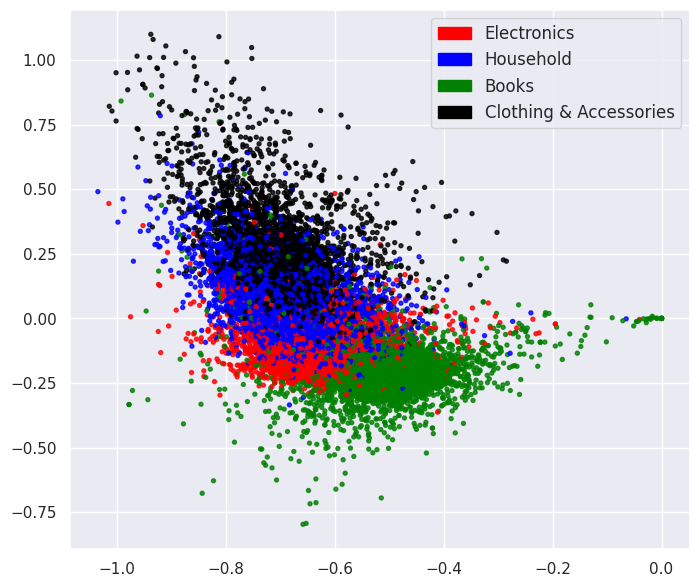

In [ ]:
# Word2Vec embedding
X_train_embed = get_word2vec_embeddings(word2vec, data_train['tokens'])
X_val_embed = get_word2vec_embeddings(word2vec, data_val['tokens'])
X_test_embed = get_word2vec_embeddings(word2vec, data_test['tokens'])

fig = plt.figure(figsize = (8, 7))
plot_embedding(X_train_embed, y_train)
plt.show()

In [ ]:
# Converting to Compressed Sparse Row matrix
X_train_w2v = scipy.sparse.csr_matrix(X_train_embed)
X_val_w2v = scipy.sparse.csr_matrix(X_val_embed)
X_test_w2v = scipy.sparse.csr_matrix(X_test_embed)

Word2Vec Baseline Modeling

In [ ]:
# Summary of baseline models
score(X_train_w2v, y_train, X_val_w2v, y_val, names = names, models = models)

,Classifier,Training accuracy,Validation accuracy
7,XGBoost,0.999955,0.943525
3,Linear SVM,0.937233,0.934173
5,SGD Classifier,0.930624,0.929137
0,Logistic Regression,0.931613,0.928777
4,Random Forest,0.999955,0.926259
6,Ridge Classifier,0.921811,0.924820
1,KNN Classifier,0.913268,0.912590
8,AdaBoost,0.856796,0.849640
2,Decision Tree,0.999955,0.816547


Word2Vec Hyperparameter Tuning

We perform **hyperparameter tuning** on the best performing baseline model.

In [ ]:
# Hyperparameter tuning for XGBoost
xgb = XGBClassifier()
params_xgb = {
    'learning_rate': [0.03, 0.3],
    'min_child_weight': [0, 10],
    'n_estimators': [200],
    'reg_lambda': [1, 2],
    'seed': [40]
}

best_model_xgb, best_params_xgb, best_score_xgb, count = xgb, ParameterGrid(params_xgb)[0], 0, 0
for g in ParameterGrid(params_xgb):
    time_start = time.time()
    count += 1
    print(f"Gridpoint #{count}: {g}")
    xgb.set_params(**g)
    xgb.fit(X_train_w2v, y_train)
    y_train_pred, y_val_pred = xgb.predict(X_train_w2v), xgb.predict(X_val_w2v)
    score_train, score_val = accuracy_score(y_train, y_train_pred), accuracy_score(y_val, y_val_pred)
    time_stop = time.time()
    m, s = int(time_stop - time_start) // 60, int(time_stop - time_start) % 60
    print(f"Training accuracy: {score_train}, Validation accuracy: {score_val}, Runtime: {m}m{s}s")
    print(" ")
    if score_val > best_score_xgb:
        best_params_xgb, best_score_xgb = g, score_val

best_model_w2v, best_params_w2v, best_score_w2v = XGBClassifier(), best_params_xgb, best_score_xgb
best_model_w2v.set_params(**best_params_w2v)
print(f"Best model: {best_model_w2v}")
print(" ")
print(f"Best parameters: {best_params_w2v}")
print(f"Best validation accuracy: {best_score_w2v}")

Gridpoint #1: {'learning_rate': 0.03, 'min_child_weight': 0, 'n_estimators': 200, 'reg_lambda': 1, 'seed': 40}
Training accuracy: 0.9729328717233937, Validation accuracy: 0.9316546762589928, Runtime: 0m34s
 
Gridpoint #2: {'learning_rate': 0.03, 'min_child_weight': 0, 'n_estimators': 200, 'reg_lambda': 2, 'seed': 40}
Training accuracy: 0.9718537835528978, Validation accuracy: 0.9320143884892086, Runtime: 0m34s
 
Gridpoint #3: {'learning_rate': 0.03, 'min_child_weight': 10, 'n_estimators': 200, 'reg_lambda': 1, 'seed': 40}
Training accuracy: 0.9689762150982419, Validation accuracy: 0.9309352517985612, Runtime: 0m28s
 
Gridpoint #4: {'learning_rate': 0.03, 'min_child_weight': 10, 'n_estimators': 200, 'reg_lambda': 2, 'seed': 40}
Training accuracy: 0.96794208893485, Validation accuracy: 0.9323741007194245, Runtime: 0m29s
 
Gridpoint #5: {'learning_rate': 0.3, 'min_child_weight': 0, 'n_estimators': 200, 'reg_lambda': 1, 'seed': 40}
Training accuracy: 0.999955037992896, Validation accuracy:

### Final Prediction and Evaluation of Baseline Models

We employ the model with the highest validation accuracy to predict the labels of the test observations and report the resulting test accuracy and confusion matrix.

In [ ]:
# Function to compute and print confusion matrix
def conf_mat(y_test, y_test_pred, figsize = (10, 8), font_scale = 1.2, annot_kws_size = 16):
    class_names = [0, 1, 2, 3] # ['Electronics', 'Household', 'Books', 'Clothing & Accessories']
    tick_marks_y = [0.5, 1.5, 2.5, 3.5]
    tick_marks_x = [0.5, 1.5, 2.5, 3.5]
    confusion_matrix = metrics.confusion_matrix(y_test, y_test_pred)
    confusion_matrix_df = pd.DataFrame(confusion_matrix, range(4), range(4))
    plt.figure(figsize = figsize)
    sns.set(font_scale = font_scale) # label size
    plt.title("Confusion Matrix")
    sns.heatmap(confusion_matrix_df, annot = True, annot_kws = {"size": annot_kws_size}, fmt = 'd') # font size
    plt.yticks(tick_marks_y, class_names, rotation = 'vertical')
    plt.xticks(tick_marks_x, class_names, rotation = 'horizontal')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)
    plt.show()

In [ ]:
# Best model
if best_score_tfidf >= best_score_w2v:
    best_model, X_train_vec, X_test_vec = best_model_tfidf, X_train_tfidf, X_test_tfidf
else:
    best_model, X_train_vec, X_test_vec = best_model_w2v, X_train_w2v, X_test_w2v

Test accuracy    0.94858
 


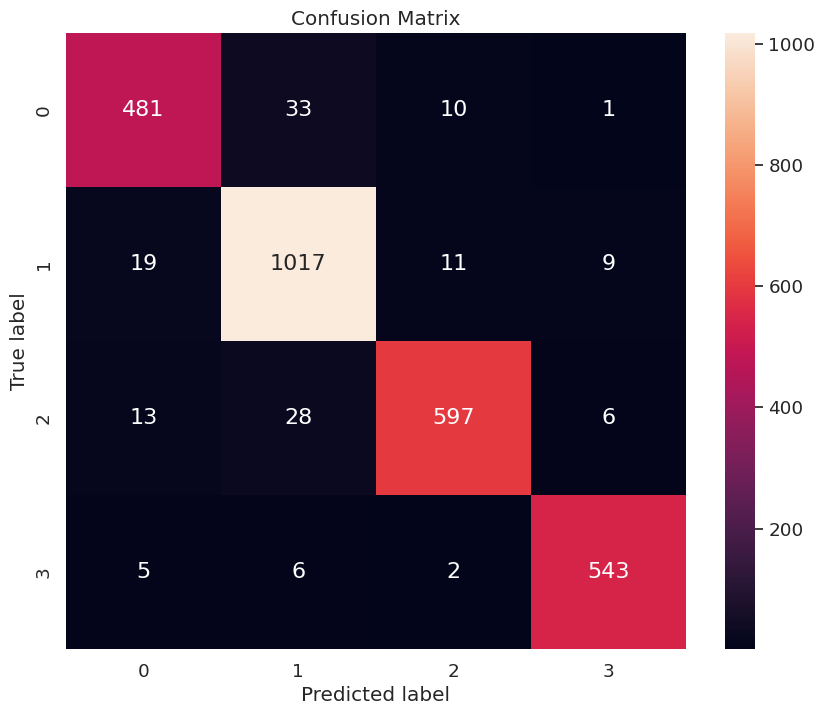

In [ ]:
# Prediction and evaluation on test set
best_model.fit(X_train_vec, y_train)
y_test_pred = best_model.predict(X_test_vec)
score_test = accuracy_score(y_test, y_test_pred)
print(pd.Series({"Test accuracy": score_test}).to_string())
print(" ")
conf_mat(y_test, y_test_pred, figsize = (10, 8), font_scale = 1.2, annot_kws_size = 16) # Confusion matrix

<h2><center> <span style = "font-family: Babas; font-size: 2em;"> E-commerce Text Classification </span> </center></h2>
<h4><center> <span style = "font-family: Babas; font-size: 2em; font-style: italic"> With SBERT, LoRA FineTune, LSTM </span> </center></h4>
<h4><center> <span style = "font-family: Babas; font-size: 2em;"> Gökalp Eren Akol </span> </center></h4>

---

The objective of the project is to classify [**e-commerce**](https://en.wikipedia.org/wiki/E-commerce) products into four categories, based on its description available in the e-commerce platforms. The categories are: `Electronics`, `Household`, `Books`, and `Clothing & Accessories`. We carried out the following steps in this notebook:

- Integrated Sentence-BERT (all-MiniLM-L6-v2) to produce semantically rich vector embeddings. These vectors were passed to classical classifiers, and a hyperparameter-tuned K-Nearest Neighbors model achieved the highest accuracy of 96%.

- Fine-tuned the same Sentence-BERT model using LoRA (Low-Rank Adaptation) to efficiently update only a small subset of model parameters. After 3 epochs of training, the model reached 92.6% validation accuracy. Further improvement was achieved by replacing the model with a larger pretrained model, all-mpnet-base, which yielded 94.4% accuracy.

- As a final deep learning experiment, we employed a basic LSTM network using PyTorch's embedding layer. The initial performance was subpar (87% accuracy), but after replacing raw embeddings with Sentence-BERT vectors, the model reached nearly 95%, making it competitive with other approaches.

---

### Sentence Bert Embedding(all-MiniLM-L6-v2) and ML classifier models
After the baseline models which - [**Text Vectorization with TF-IDF**](#Text-Vectorization) and [**Word Embeddings with Word2Vec**](#Word-Embedding), I will retrain same models by embedding with Sentence Bert model.

In [ ]:
!pip install peft transformers accelerate
from sentence_transformers import SentenceTransformer

from sklearn.model_selection import ParameterGrid
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from peft import get_peft_model, LoraConfig, TaskType

import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

from sklearn.preprocessing import LabelEncoder

import pickle

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

sbert_model = SentenceTransformer('all-MiniLM-L6-v2', device=device)

Using device: cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In here, I will train the `Logistic Regression Classifier` to see if there is any problem. After that, I will continue training other ML Classifiers.

If we look at the results, we can see that Logistic Regression is predicting with accuracy of 0.9366. So we will continue implementing other

In [ ]:

X_train_sbert = data_train['description'].tolist()
X_val_sbert   = data_val['description'].tolist()
X_test_sbert  = data_test['description'].tolist()

y_train = data_train['label'].tolist()
y_val   = data_val['label'].tolist()
y_test  = data_test['label'].tolist()

X_train_embed = sbert_model.encode(X_train_sbert, convert_to_numpy=True, show_progress_bar=True)
X_val_embed   = sbert_model.encode(X_val_sbert, convert_to_numpy=True, show_progress_bar=True)
X_test_embed  = sbert_model.encode(X_test_sbert, convert_to_numpy=True, show_progress_bar=True)

model = LogisticRegression(max_iter=1000)
model.fit(X_train_embed, y_train)

y_train_pred = model.predict(X_train_embed)
y_val_pred   = model.predict(X_val_embed)
y_test_pred  = model.predict(X_test_embed)

print("Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("Val Accuracy:  ", accuracy_score(y_val, y_val_pred))
print("Test Accuracy: ", accuracy_score(y_test, y_test_pred))

Batches:   0%|          | 0/696 [00:00<?, ?it/s]

Batches:   0%|          | 0/87 [00:00<?, ?it/s]

Batches:   0%|          | 0/87 [00:00<?, ?it/s]

Train Accuracy: 0.9420439728429477
Val Accuracy:   0.9366906474820144
Test Accuracy:  0.9385113268608414


In [ ]:
names = [
    "Logistic Regression",
    "KNN Classifier",
    "Decision Tree",
    "Linear SVM",
    "Random Forest",
    "SGD Classifier",
    "Ridge Classifier",
    "XGBoost",
    "AdaBoost",
]

models = [
    LogisticRegression(max_iter=1000),
    KNeighborsClassifier(n_neighbors=5),
    DecisionTreeClassifier(),
    svm.SVC(kernel='linear'),
    RandomForestClassifier(n_estimators=100),
    SGDClassifier(loss='hinge'),
    RidgeClassifier(),
    XGBClassifier(),
    AdaBoostClassifier()
]

In [ ]:
def score(X_train, y_train, X_val, y_val, names=names, models=models):
    score_df, score_train, score_val = pd.DataFrame(), [], []
    for model in models:
        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)
        score_train.append(accuracy_score(y_train, y_train_pred))
        score_val.append(accuracy_score(y_val, y_val_pred))
    score_df["Classifier"] = names
    score_df["Training accuracy"] = score_train
    score_df["Validation accuracy"] = score_val
    score_df.sort_values(by='Validation accuracy', ascending=False, inplace=True)
    return score_df


In [ ]:
results_df_1 = score(X_train_embed, y_train, X_val_embed, y_val)
print(results_df_1)

            Classifier  Training accuracy  Validation accuracy
1       KNN Classifier           0.969066             0.956115
7              XGBoost           1.000000             0.944604
3           Linear SVM           0.946136             0.938849
0  Logistic Regression           0.942044             0.936691
5       SGD Classifier           0.939166             0.936331
6     Ridge Classifier           0.934850             0.932734
4        Random Forest           1.000000             0.932374
8             AdaBoost           0.821141             0.817626
2        Decision Tree           1.000000             0.768705


Among all of the models the `KNN Classifier` performs best when using Sentence BERT embeddings. `KNN Classifier` gives us accuracy of `0.956` which is good. Now I will use hyperparameter tuning for KNN Classifier.

With tuning, KNN gives us accuracy of 0.9615 in validation set with {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'} parameters

In [ ]:

params_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

best_model, best_params, best_score = None, None, 0

for g in ParameterGrid(params_knn):
    clf = KNeighborsClassifier(**g)
    clf.fit(X_train_embed, y_train)
    val_pred = clf.predict(X_val_embed)
    acc = accuracy_score(y_val, val_pred)
    if acc > best_score:
        best_model = clf
        best_score = acc
        best_params = g

print("Best Parameters:", best_params)
print("Best Validation Accuracy:", best_score)


Best Parameters: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}
Best Validation Accuracy: 0.9615107913669064


In here, I used pickle library in order to save the data.

In [ ]:
#with open("data_train.pkl", "wb") as f:
#    pickle.dump(data_train, f)
#with open("data_val.pkl", "wb") as f:
#    pickle.dump(data_val, f)
#with open("data_test.pkl", "wb") as f:
#    pickle.dump(data_test, f)

In [ ]:
#with open("data_train.pkl", "rb") as f:
#    data_train = pickle.load(f)
#with open("data_val.pkl", "rb") as f:
#    data_val = pickle.load(f)
#with open("data_test.pkl", "rb") as f:
#    data_test = pickle.load(f)


In [ ]:
#data_train.to_csv("data_train.csv", index=False)
#data_val.to_csv("data_val.csv", index=False)
#data_test.to_csv("data_test.csv", index=False)

In [ ]:
#data_train = pd.read_csv("data_train.csv")
#data_val = pd.read_csv("data_val.csv")
#data_test = pd.read_csv("data_test.csv")

### Parameter Efficient Finetuning language Models For Classification

After working with embedding + ML Classifiers Model [**Sentence Bert Embedding(all-MiniLM-L6-v2) and ML classifier models**](#Sentence-Bert-Embedding-all-MiniLM-L6-v2) and ML classifier models) , Now we will `LoRA Fine Tune all-MiniLM-L6-v2` model for classification task.



Pre trained "all-MiniLM-L6-v2" Sentence BERT model is prepared to be finetuned into classification task. Different from classic fine tuning, we will use LoRA which only certain layers are going to be changed. With this technique we wont spend so much resources and we wont update all of the parameters.

We are starting with initializing the configuration parameters for lora and model. After that we are using PyTorch dataset and dataloader to feed the data into the model. When we finetuning the model, we will use `Adam` as our optimizer and `crossentropy loss` as our loss function, and we will train the model with 3 epochs.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_id = "sentence-transformers/all-MiniLM-L6-v2"


tokenizer = AutoTokenizer.from_pretrained(model_id)


base_model = AutoModelForSequenceClassification.from_pretrained(
    model_id,
    num_labels=len(set(y_train))
)


lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["query", "value"],
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.SEQ_CLS
)


model = get_peft_model(base_model, lora_config)
model.print_trainable_parameters()
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/all-MiniLM-L6-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 75,268 || all params: 22,790,024 || trainable%: 0.3303


PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): BertForSequenceClassification(
      (bert): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 384, padding_idx=0)
          (position_embeddings): Embedding(512, 384)
          (token_type_embeddings): Embedding(2, 384)
          (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0-5): 6 x BertLayer(
              (attention): BertAttention(
                (self): BertSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=384, out_features=384, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default):

In [ ]:

class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoded = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )
        return {
            "input_ids": encoded["input_ids"].squeeze(),
            "attention_mask": encoded["attention_mask"].squeeze(),
            "label": torch.tensor(self.labels[idx], dtype=torch.long)
        }


train_dataset = TextDataset(X_train_sbert, y_train, tokenizer)
val_dataset   = TextDataset(X_val_sbert, y_val, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=16)


In [ ]:

optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

epochs = 3
model.train()

for epoch in range(epochs):
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}")
    total_loss = 0
    for batch in loop:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    print(f"Epoch {epoch+1} loss: {total_loss / len(train_loader):.3f}")


Epoch 1: 100%|██████████| 1391/1391 [00:56<00:00, 24.47it/s, loss=0.613]


Epoch 1 loss: 1.1870


Epoch 2: 100%|██████████| 1391/1391 [00:52<00:00, 26.40it/s, loss=0.182]


Epoch 2 loss: 0.5905


Epoch 3: 100%|██████████| 1391/1391 [00:53<00:00, 26.05it/s, loss=0.0995]

Epoch 3 loss: 0.3592


In [ ]:
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

val_acc_2 = accuracy_score(all_labels, all_preds)
print(f"Validation Accuracy: {val_acc_2:.3f}")


Validation Accuracy: 0.9291


After all-MiniLM-L6-v2 [**Parameter Efficient Finetuning all-MiniLM-L6-v2 For Classification**](#Parameter-Efficient-Finetuning-language-Models-For-Classification), model predicted with an accuracy of 0.929 which can be increased with more epochs and parameter tuning. But now we will `LoRA Fine Tune all-mpnet-base-v2` model for classification task.


The process consist of same steps with miniLM Fine Tuning. But the model scale is changing. The `all-MiniLM-L6-v2` model pretrained with 22.7M Parameters. But the `all-mpnet-base-v2` has 109M params. So we are expecting more understanding in terms of context from this model, and we are expecting more accurate predictions from this model.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_id = "sentence-transformers/all-mpnet-base-v2"
tokenizer = AutoTokenizer.from_pretrained(model_id)

base_model = AutoModelForSequenceClassification.from_pretrained(
    model_id,
    num_labels=len(set(y_train))
)

lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["attn.q", "attn.v"],
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.SEQ_CLS
)


model = get_peft_model(base_model, lora_config)
model.to(device)
model.print_trainable_parameters()


Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/all-mpnet-base-v2 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 888,580 || all params: 110,378,120 || trainable%: 0.8050


In [ ]:

class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoded = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )
        return {
            "input_ids": encoded["input_ids"].squeeze(),
            "attention_mask": encoded["attention_mask"].squeeze(),
            "label": torch.tensor(self.labels[idx], dtype=torch.long)
        }

train_dataset = TextDataset(X_train_sbert, y_train, tokenizer)
val_dataset   = TextDataset(X_val_sbert, y_val, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=16)


In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

for epoch in range(3):
    model.train()
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}")
    for batch in loop:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        loop.set_postfix(loss=loss.item())


Epoch 3: 100%|██████████| 1391/1391 [06:47<00:00,  3.41it/s, loss=0.0511]


In [ ]:
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

val_acc_3 = accuracy_score(all_labels, all_preds)
print(f"Validation Accuracy: {val_acc_3:.3f}")


Validation Accuracy: 0.9511


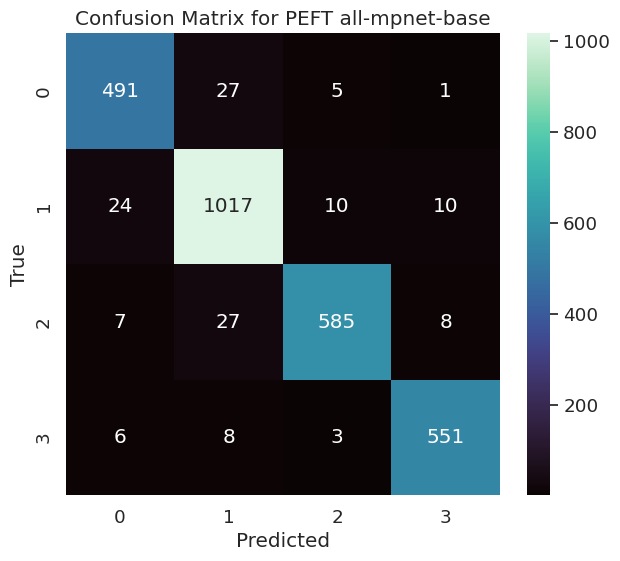


Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.94      0.93       524
           1       0.94      0.96      0.95      1061
           2       0.97      0.93      0.95       627
           3       0.97      0.97      0.97       568

    accuracy                           0.95      2780
   macro avg       0.95      0.95      0.95      2780
weighted avg       0.95      0.95      0.95      2780



In [ ]:
cm = confusion_matrix(all_labels, all_preds)
labels = sorted(list(set(all_labels)))
class_names = [str(label) for label in labels]

plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, cmap='mako', fmt='d')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for PEFT all-mpnet-base")
plt.show()


print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, target_names=class_names))

### Text Classification with torch Embeddings + LSTM

An nn.Embedding layer maps tokens to vectors, which are passed through an LSTM and a fully connected layer for classification. The model is trained with LSTM layer with no bidirectional and attention.


In [85]:
import nltk
from nltk.tokenize import RegexpTokenizer

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from collections import Counter
import numpy as np

In [86]:
val_accuracies = []

In [87]:
tokenizer = RegexpTokenizer(r'\w+')

def convert_to_lowercase(text):
    return text.lower()

def convert_contractions(text):
    words = []
    for word in tokenizer.tokenize(text):
        lw = word.lower()
        if lw in contractions_dict:
            words.extend(contractions_dict[lw].split())
        else:
            words.append(word)
    return " ".join(words)

for df in [data_train, data_val, data_test]:
    df['normalized_text'] = df["description"].apply(convert_to_lowercase).apply(convert_contractions)
    df['tokens'] = df['normalized_text'].apply(tokenizer.tokenize)


In [88]:
texts = data_train['description'].astype(str).tolist()
labels = data_train['label'].tolist()


le = LabelEncoder()
labels_encoded = le.fit_transform(labels)


X_train, X_val, y_train, y_val = train_test_split(texts, labels_encoded, test_size=0.2, random_state=42)


In [89]:
def tokenize(text):
    return text.lower().split()


all_tokens = []
for sent in X_train:
    all_tokens.extend(tokenize(sent))


vocab_size = 10000
freqs = Counter(all_tokens)
most_common = freqs.most_common(vocab_size - 2)
word2idx = {word: idx+2 for idx, (word, _) in enumerate(most_common)}
word2idx["<PAD>"] = 0
word2idx["<OOV>"] = 1

def encode_sentence(sentence, word2idx, max_len=100):
    tokens = tokenize(sentence)
    encoded = [word2idx.get(token, word2idx["<OOV>"]) for token in tokens]

    if len(encoded) < max_len:
        encoded = encoded + [word2idx["<PAD>"]] * (max_len - len(encoded))
    else:
        encoded = encoded[:max_len]
    return encoded


In [90]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, word2idx, max_len=100):
        self.texts = texts
        self.labels = labels
        self.word2idx = word2idx
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoded_text = encode_sentence(self.texts[idx], self.word2idx, self.max_len)
        label = self.labels[idx]
        return torch.tensor(encoded_text, dtype=torch.long), torch.tensor(label, dtype=torch.long)

max_len = 100
train_dataset = TextDataset(X_train, y_train, word2idx, max_len)
val_dataset = TextDataset(X_val, y_val, word2idx, max_len)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


In [91]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers=1, dropout=0.5):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, batch_first=True, dropout=0.5)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, (hidden, cell) = self.lstm(embedded)
        out = self.dropout(hidden[-1])
        out = self.fc(out)
        return out

embedding_dim = 100
hidden_dim = 128
output_dim = len(le.classes_)
model = LSTMClassifier(len(word2idx), embedding_dim, hidden_dim, output_dim)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1



In [92]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train(model, loader):
    model.train()
    total_loss = 0
    for texts, labels in loader:
        texts, labels = texts.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(texts)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for texts, labels in loader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    accuracy = correct / total
    return total_loss / len(loader), accuracy


In [93]:
n_epochs = 10

for epoch in range(n_epochs):
    train_loss = train(model, train_loader)
    val_loss, val_acc = evaluate(model, val_loader)
    val_accuracies.append(val_acc)
    print(f"Epoch {epoch+1}/{n_epochs} | Train Loss: {train_loss:.3f} | Val Loss: {val_loss:.3f} | Val Acc: {val_acc:.3f}")


Epoch 1/10 | Train Loss: 1.2958 | Val Loss: 1.3578 | Val Acc: 0.3882
Epoch 2/10 | Train Loss: 1.2021 | Val Loss: 1.0934 | Val Acc: 0.5374
Epoch 3/10 | Train Loss: 1.1619 | Val Loss: 1.0471 | Val Acc: 0.5765
Epoch 4/10 | Train Loss: 1.0263 | Val Loss: 0.9687 | Val Acc: 0.6129
Epoch 5/10 | Train Loss: 1.2329 | Val Loss: 1.0640 | Val Acc: 0.5588
Epoch 6/10 | Train Loss: 0.9221 | Val Loss: 0.9025 | Val Acc: 0.6909
Epoch 7/10 | Train Loss: 0.7528 | Val Loss: 0.7379 | Val Acc: 0.6826
Epoch 8/10 | Train Loss: 0.8188 | Val Loss: 0.7291 | Val Acc: 0.6945
Epoch 9/10 | Train Loss: 0.6812 | Val Loss: 0.6149 | Val Acc: 0.7968
Epoch 10/10 | Train Loss: 0.5825 | Val Loss: 0.4786 | Val Acc: 0.8557


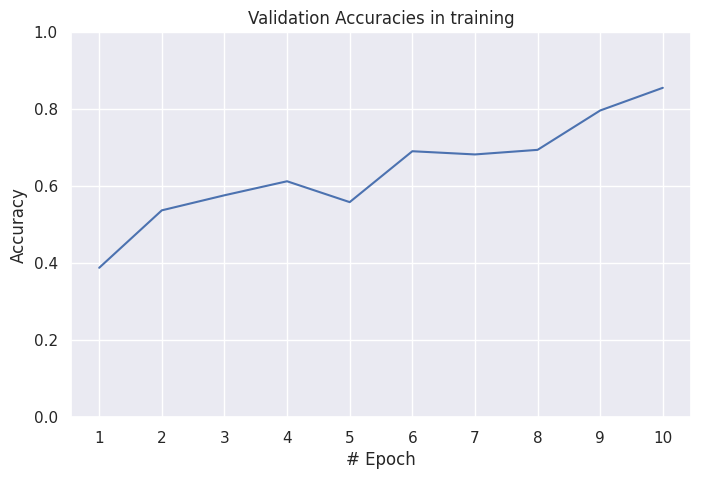

In [94]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, n_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.title('Validation Accuracies in training')
plt.xlabel('# Epoch')
plt.ylabel('Accuracy')
plt.xticks(range(1, n_epochs + 1))
plt.ylim(0, 1)
plt.show()


### Text Classification with BERT Tokenizer + LSTM


In here, we will use a pre-trained BERT model to extract contextual embeddings from input text, which are then fed into an LSTM-based classifier. This hybrid approach will use BERT’s language understanding with LSTM’s sequence modeling ability for effective text classification.


In [ ]:
from transformers import BertTokenizer, BertModel

In [99]:
class BertDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=50):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        inputs = self.tokenizer(text, max_length=self.max_len, padding='max_length', truncation=True, return_tensors='pt')
        return {
            'input_ids': inputs['input_ids'].squeeze(0),
            'attention_mask': inputs['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }


In [100]:
class BertEmbeddingLSTMClassifier(nn.Module):
    def __init__(self, bert_embedding_dim=768, hidden_dim=128, output_dim=2, n_layers=1, dropout=0.5):
        super().__init__()
        self.lstm = nn.LSTM(bert_embedding_dim, hidden_dim, num_layers=n_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, (hidden, cell) = self.lstm(x)
        out = self.dropout(hidden[-1])
        out = self.fc(out)
        return out


In [101]:
def train_bert_embedding_lstm(model, bert_model, dataloader, optimizer, criterion, device):
    model.train()
    bert_model.eval()

    total_loss = 0
    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        with torch.no_grad():
            bert_outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)
            embeddings = bert_outputs.last_hidden_state

        optimizer.zero_grad()
        outputs = model(embeddings)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(dataloader)


In [102]:
def evaluate_bert_embedding_lstm(model, bert_model, dataloader, criterion, device):
    model.eval()
    bert_model.eval()

    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            bert_outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)
            embeddings = bert_outputs.last_hidden_state

            outputs = model(embeddings)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    return total_loss / len(dataloader), accuracy


In [103]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)

train_dataset = BertDataset(X_train, y_train, tokenizer, max_len=50)
val_dataset = BertDataset(X_val, y_val, tokenizer, max_len=50)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

model = BertEmbeddingLSTMClassifier(output_dim=len(le.classes_)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

n_epochs = 10
for epoch in range(n_epochs):
    train_loss = train_bert_embedding_lstm(model, bert_model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate_bert_embedding_lstm(model, bert_model, val_loader, criterion, device)
    print(f"Epoch {epoch+1}/{n_epochs} | Train Loss: {train_loss:.3f} | Val Loss: {val_loss:.3f} | Val Acc: {val_acc:.3f}")


Epoch 1/10 | Train Loss: 0.381 | Val Loss: 0.269 | Val Acc: 0.925
Epoch 2/10 | Train Loss: 0.277 | Val Loss: 0.256 | Val Acc: 0.923
Epoch 3/10 | Train Loss: 0.237 | Val Loss: 0.233 | Val Acc: 0.933
Epoch 4/10 | Train Loss: 0.209 | Val Loss: 0.222 | Val Acc: 0.942
Epoch 5/10 | Train Loss: 0.182 | Val Loss: 0.215 | Val Acc: 0.943
Epoch 6/10 | Train Loss: 0.159 | Val Loss: 0.215 | Val Acc: 0.943
Epoch 7/10 | Train Loss: 0.142 | Val Loss: 0.211 | Val Acc: 0.944
Epoch 8/10 | Train Loss: 0.113 | Val Loss: 0.237 | Val Acc: 0.931
Epoch 9/10 | Train Loss: 0.104 | Val Loss: 0.212 | Val Acc: 0.946
Epoch 10/10 | Train Loss: 0.091 | Val Loss: 0.200 | Val Acc: 0.948
